# Parsed payload 분석

# import

In [118]:
import pandas as pd
import glob
from tqdm.notebook import tqdm

# convert Func

In [98]:
def concat_mac_to_int(x):
    return int("".join(x.split(":")), 16)


def hex_to_int(x):
    return int(x, 16)


def ipv4_to_int(x):
    x = [int(each) for each in x.split(".")]
    out = 1
    for t_x in x:
        out *= t_x
    return out

# dataLoad

In [19]:
pd.set_option('display.max_columns', 50)

In [4]:
train_df = pd.read_pickle("E:/full_data/data/protocols/network/HH/all_train_df.pkl")
test_df = pd.read_pickle("E:/full_data/data/protocols/network/HH/all_test_df.pkl")

# preprocess

In [6]:
temptcp = {'Source port': 37748,
 'Destination port': 80,
 'Sequence number': '0x91d90ca8',
 'Acknowledgment number': '0x4ba54335',
 'Data offset': 8,
 'Reserved': 0,
 'Flags': {'NS': 0,
  'CWR': 0,
  'ECE ': 0,
  'URG': 0,
  'ACK': 1,
  'PSH': 1,
  'RST': 0,
  'SYN': 0,
  'FIN': 0},
 'Window size': 229,
 'Checksum': '0x7799',
 'Urgent pointer': 0}

In [8]:
tcp_keys = list(temptcp.keys())

In [9]:
def extract_tcp_info(df, tcp_keys):
    tcp_data = {}
    for idx in tqdm(df.index):
        tcp = df["TCP"][idx]
        for key in tcp_keys:
            if key not in tcp_data:
                tcp_data[key] = []
            tcp_data[key].append(tcp[key])
    return tcp_data

In [10]:
train_tcp = extract_tcp_info(train_df, tcp_keys)

In [11]:
test_tcp = extract_tcp_info(test_df, tcp_keys)

In [13]:
train_idxs = list(train_df.index)
train_tcp_df = pd.DataFrame(data=train_tcp, index=train_idxs)

In [15]:
test_idxs = list(test_df.index)
test_tcp_df = pd.DataFrame(data=test_tcp, index=test_idxs)

In [16]:
train_df_with_tcp = pd.merge(train_df, train_tcp_df, left_index=True, right_index=True, how="outer")

In [17]:
test_df_with_tcp = pd.merge(test_df, test_tcp_df, left_index=True, right_index=True, how="outer")

In [21]:
del train_df_with_tcp['TCP']
del test_df_with_tcp['TCP']

In [23]:
train_dst_mac = train_df_with_tcp['Destination MAC Address']
train_src_mac = train_df_with_tcp['Source MAC Address']

In [27]:
test_dst_mac = test_df_with_tcp['Destination MAC Address']
test_src_mac = test_df_with_tcp['Source MAC Address']

In [24]:
macs = []
for i in range(6):
    macs.append("dst_mac_addr_"+str(i))
    macs.append("src_mac_addr_"+str(i))

In [26]:
concat_train_dst_mac = train_dst_mac.apply(concat_mac_to_int)
concat_train_src_mac = train_src_mac.apply(concat_mac_to_int)

In [28]:
concat_test_dst_mac = test_dst_mac.apply(concat_mac_to_int)
concat_test_src_mac = test_src_mac.apply(concat_mac_to_int)

In [34]:
train_df_with_tcp["Ether Type"] = train_df_with_tcp["Ether Type"].apply(hex_to_int)
train_df_with_tcp["Header Checksum"] = train_df_with_tcp["Header Checksum"].apply(hex_to_int)
train_df_with_tcp["Sequence number"] = train_df_with_tcp["Sequence number"].apply(hex_to_int)
train_df_with_tcp["Acknowledgment number"] = train_df_with_tcp["Acknowledgment number"].apply(hex_to_int)
train_df_with_tcp["Checksum"] = train_df_with_tcp["Checksum"].apply(hex_to_int)

In [35]:
test_df_with_tcp["Ether Type"] = test_df_with_tcp["Ether Type"].apply(hex_to_int)
test_df_with_tcp["Header Checksum"] = test_df_with_tcp["Header Checksum"].apply(hex_to_int)
test_df_with_tcp["Sequence number"] = test_df_with_tcp["Sequence number"].apply(hex_to_int)
test_df_with_tcp["Acknowledgment number"] = test_df_with_tcp["Acknowledgment number"].apply(hex_to_int)
test_df_with_tcp["Checksum"] = test_df_with_tcp["Checksum"].apply(hex_to_int)

In [39]:
flags = []
for _ in range(9):
    flags.append([])
    
for idx in tqdm(train_idxs):
    for i, v in enumerate(list(train_df_with_tcp["Flags_y"][idx].values())):
        flags[i].append(v)

In [41]:
train_flags_df = pd.DataFrame(data={
    "flags0":flags[0], "flags0":flags[0],
    "flags2":flags[2], "flags1":flags[1],
    "flags4":flags[4], "flags3":flags[3],
    "flags6":flags[6], "flags5":flags[5],
    "flags8":flags[8]    
}, index=train_idxs)

In [42]:
flags = []
for _ in range(9):
    flags.append([])

for idx in tqdm(test_idxs):
    for i, v in enumerate(list(test_df_with_tcp["Flags_y"][idx].values())):
        flags[i].append(v)
        
test_flags_df = pd.DataFrame(data={
    "flags0":flags[0], "flags0":flags[0],
    "flags2":flags[2], "flags1":flags[1],
    "flags4":flags[4], "flags3":flags[3],
    "flags6":flags[6], "flags5":flags[5],
    "flags8":flags[8]    
}, index=test_idxs)

In [43]:
train_df_with_tcp_flags = pd.merge(train_df_with_tcp, train_flags_df, left_index=True, right_index=True, how="outer")

In [44]:
test_df_with_tcp_flags = pd.merge(test_df_with_tcp, test_flags_df, left_index=True, right_index=True, how="outer")

In [49]:
train_df_with_tcp_flags["Destination MAC Address"] = concat_train_dst_mac
train_df_with_tcp_flags["Source MAC Address"] = concat_train_src_mac

In [51]:
test_df_with_tcp_flags["Destination MAC Address"] = concat_test_dst_mac
test_df_with_tcp_flags["Source MAC Address"] = concat_test_src_mac

In [70]:
train_df_with_tcp_flags["Source IP Address"] = train_df_with_tcp_flags["Source IP Address"].apply(ipv4_to_int)
train_df_with_tcp_flags["Destination IP Address"] = train_df_with_tcp_flags["Destination IP Address"].apply(ipv4_to_int)

In [71]:
test_df_with_tcp_flags["Source IP Address"] = test_df_with_tcp_flags["Source IP Address"].apply(ipv4_to_int)
test_df_with_tcp_flags["Destination IP Address"] = test_df_with_tcp_flags["Destination IP Address"].apply(ipv4_to_int)

In [74]:
del train_df_with_tcp_flags["Flags_y"]
del test_df_with_tcp_flags['Flags_y']

In [99]:
train_df_with_tcp["Source IP Address"] = train_df_with_tcp["Source IP Address"].apply(ipv4_to_int)
train_df_with_tcp["Destination IP Address"] = train_df_with_tcp["Destination IP Address"].apply(ipv4_to_int)

In [100]:
test_df_with_tcp["Source IP Address"] = test_df_with_tcp["Source IP Address"].apply(ipv4_to_int)
test_df_with_tcp["Destination IP Address"] = test_df_with_tcp["Destination IP Address"].apply(ipv4_to_int)

In [101]:
train_src_ip = train_df_with_tcp["Source IP Address"]
train_dst_ip = train_df_with_tcp["Destination IP Address"]

In [102]:
test_src_ip = test_df_with_tcp["Source IP Address"]
test_dst_ip = test_df_with_tcp["Destination IP Address"]

In [103]:
train_df_with_tcp_flags["Source IP Address"] = train_src_ip
train_df_with_tcp_flags["Destination IP Address"] = train_dst_ip

In [105]:
test_df_with_tcp_flags["Source IP Address"] = test_src_ip
test_df_with_tcp_flags["Destination IP Address"] = test_dst_ip

In [125]:
train_df_with_tcp["Flags_y"]['0000127a-3659-4318-8dcf-9ab81f9a4050']

{'NS': 0,
 'CWR': 0,
 'ECE ': 0,
 'URG': 0,
 'ACK': 1,
 'PSH': 0,
 'RST': 0,
 'SYN': 0,
 'FIN': 0}

In [119]:
train_df_with_tcp_flags

,Destination MAC Address,Source MAC Address,Ether Type,Version,Internet Header Length,Differentiated Services Code Point,Explicit Congestion Notification,Total Length,Identification,Flags_x,Fragment Offset,Time To Live,Protocol,Header Checksum,Source IP Address,Destination IP Address,Source port,Destination port,Sequence number,Acknowledgment number,Data offset,Reserved,Window size,Checksum,Urgent pointer,flags0,flags2,flags1,flags4,flags3,flags6,flags5,flags8
0000127a-3659-4318-8dcf-9ab81f9a4050,97113814912,112490399296,2048,4,5,0,0,1500,30401,2,0,124,6,52508,42337680,172523520,31619,80,3275710569,614171435,5,0,256,42027,0,0,0,0,1,0,0,0,0
0000282d-9cc0-417b-a8ba-e9ddd0f51907,211551555070016,88226781932672,2048,4,5,0,0,345,25865,2,0,59,6,23219,800351552,504509280,60574,443,499434802,3047458819,8,0,229,21253,0,0,0,0,1,0,0,1,0
00003f54-1a7e-461a-905a-8b338ccf51ed,189803579077441,83200487040,2048,4,5,0,0,60,22946,2,0,50,6,30432,34334520,130559520,45150,443,171426392,3241858359,8,0,315,17132,0,0,0,0,1,0,0,1,0
00005ba0-df6e-4f2e-8bc7-56587e924323,97113814912,112490399296,2048,4,5,0,0,1500,20320,2,0,124,6,57657,42337680,44204992,20865,80,200267589,1098221861,5,0,256,55433,0,0,0,0,1,0,0,0,0
000086c0-6c17-4dcb-a3f4-7687bfa50917,47029714112,106225803332964,2048,4,5,0,0,286,50166,2,0,55,6,20864,60096344,37102500,61611,443,1069045392,3290897116,8,0,115,65255,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffffeffd-e46f-4916-9580-6f67a7d959bf,112490399296,97113814912,2048,4,5,0,0,1500,27455,2,0,53,6,53988,66877184,7283640,80,40400,1126729542,3427396664,5,0,237,45026,0,0,0,0,1,0,0,0,0
fffff010-6df7-4d05-b014-84248b8d1fad,618663970892,896767197125,2048,4,5,0,0,40,39972,2,0,44,6,50288,70718760,19035324,80,58997,1492736584,2241807964,5,0,65535,23446,0,0,0,0,1,0,0,0,0
fffff61d-3525-4938-a736-261ccb123c47,29066665506,238257139002241,2048,4,5,0,0,40,8348,2,0,53,6,41241,65572416,665873292,6060,54196,3440026943,1911131628,5,0,123,52669,0,0,0,0,1,0,0,0,0
fffff716-1f43-4f5f-a62b-2d1c9a26b3ba,893392113664,163544444160,2048,4,5,0,0,40,114,2,0,63,6,55959,77048760,53086000,80,58399,2386332287,798213201,5,0,65535,24060,0,0,0,0,1,0,0,0,1


In [120]:
pd.to_pickle(train_df_with_tcp_flags, r"E:\exp_with_YJ\train_df_with_tcp_flags.pkl")

In [121]:
pd.to_pickle(test_df_with_tcp_flags, r"E:\exp_with_YJ\test_df_with_tcp_flags.pkl")

# labelling

In [78]:
train_analy_1 = pd.read_pickle("E:/full_data/data/protocols/network/HH/train_1_df_label.pkl")
train_analy_2 = pd.read_pickle("E:/full_data/data/protocols/network/HH/train_2_df_label.pkl")

In [79]:
test_analy_1 = pd.read_pickle("E:/full_data/data/protocols/network/HH/test_1_df_label.pkl")
test_analy_2 = pd.read_pickle("E:/full_data/data/protocols/network/HH/test_2_df_label.pkl")

In [83]:
train_labels = []
for idx in tqdm(train_df_with_tcp_flags.index):
    if idx in train_analy_1:
        train_labels.append(1)
    elif idx in train_analy_2:
        train_labels.append(0)
    else:
        train_labels.append(3)

In [84]:
test_labels = []
for idx in tqdm(test_df_with_tcp_flags.index):
    if idx in test_analy_1:
        test_labels.append(1)
    elif idx in test_analy_2:
        test_labels.append(0)
    else:
        test_labels.append(3)

In [122]:
pd.to_pickle(train_labels, r"E:\exp_with_YJ\train_labels.pkl")
pd.to_pickle(test_labels, r"E:\exp_with_YJ\test_labels.pkl")

# EXPERIMENT

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [108]:
forest2 = RandomForestClassifier()

In [109]:
forest2.fit(train_df_with_tcp_flags, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [110]:
y_pred = forest2.predict(test_df_with_tcp_flags)

# 정확도 확인
print('정확도 :', metrics.accuracy_score(test_labels, y_pred))

정확도 : 0.8231028299577193


In [113]:
imp = forest2.feature_importances_

train_cols = list(train_df_with_tcp_flags.columns)

imp_dic = {}
for c, i in zip(train_cols, imp):
    imp_dic[c]=i

sort_imp = sorted(imp_dic.items(), key=(lambda x: x[1]), reverse=False)

imp_cols = []
imp_imp = []
for i in sort_imp:
    imp_cols.append(i[0])
    imp_imp.append(i[1])

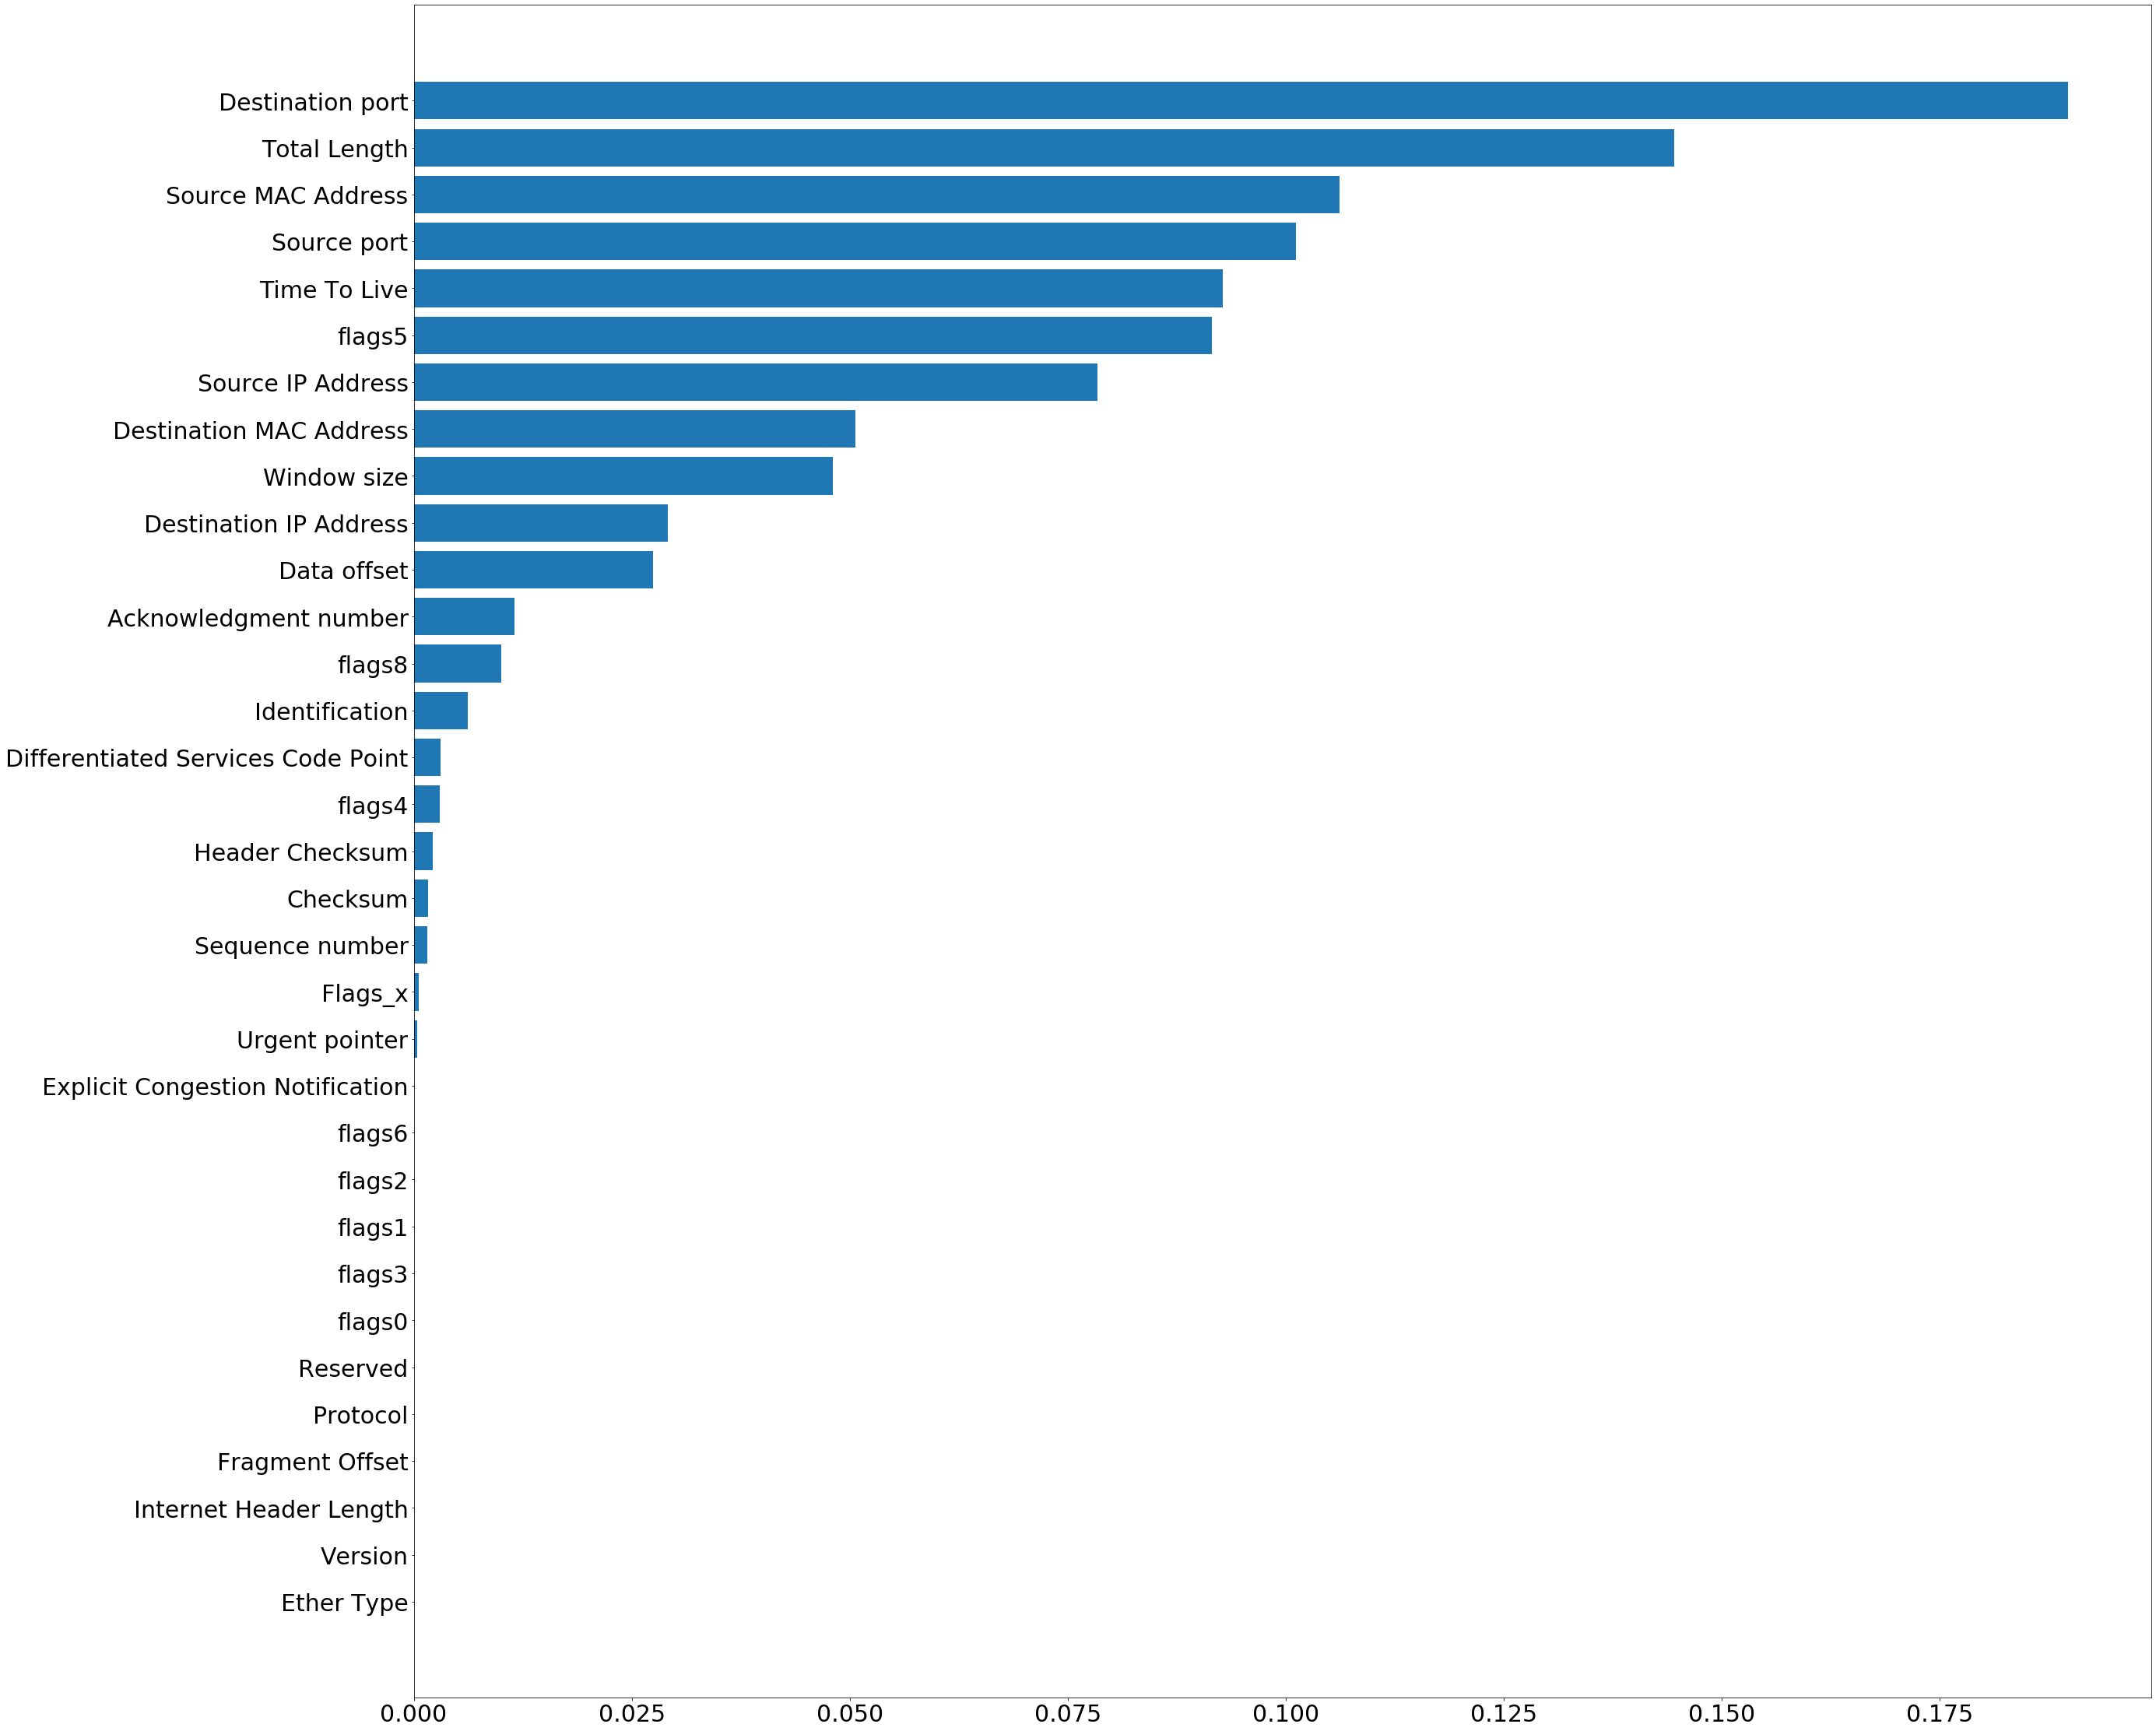

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.barh(imp_cols, imp_imp)
plt.savefig(r'E:\concat_ip.png')
plt.show()

In [2]:
pathes = glob.glob("E:/full_data/data/protocols/network/HH/*df.pkl")

In [4]:
train = pathes[2:]

In [8]:
test = pathes[:2]

In [10]:
train_df = pd.DataFrame()
for path in train:
    temp = pd.read_pickle(path)
    train_df = pd.concat([train_df, temp])

In [11]:
test_df = pd.DataFrame()
for path in test:
    temp = pd.read_pickle(path)
    test_df = pd.concat([test_df, temp])

In [18]:
pd.to_pickle(train_df, "E:/full_data/data/protocols/network/HH/all_train_df.pkl")

In [19]:
pd.to_pickle(test_df, "E:/full_data/data/protocols/network/HH/all_test_df.pkl")

In [12]:
len(train_df)

3354174

In [13]:
len(test_df)

1057931

In [23]:
temptemp = {'Source port': 37748,
 'Destination port': 80,
 'Sequence number': '0x91d90ca8',
 'Acknowledgment number': '0x4ba54335',
 'Data offset': 8,
 'Reserved': 0,
 'Flags': {'NS': 0,
  'CWR': 0,
  'ECE ': 0,
  'URG': 0,
  'ACK': 1,
  'PSH': 1,
  'RST': 0,
  'SYN': 0,
  'FIN': 0},
 'Window size': 229,
 'Checksum': '0x7799',
 'Urgent pointer': 0}

In [25]:
tcp_keys = list(temptemp.keys())

In [26]:
tcp_data = {}
for idx in tqdm(train_df.index):
    tcp = train_df["TCP"][idx]
    for key in tcp_keys:
        if key not in tcp_data:
            tcp_data[key] = []
        tcp_data[key].append(tcp[key])

In [31]:
idxs = list(train_df.index)
tcp_df = pd.DataFrame(data=tcp_data, index=idxs)

In [32]:
tcp_df

,Source port,Destination port,Sequence number,Acknowledgment number,Data offset,Reserved,Flags,Window size,Checksum,Urgent pointer
0000127a-3659-4318-8dcf-9ab81f9a4050,31619,80,0xc33f6069,0x249b832b,5,0,"{'NS': 0, 'CWR': 0, 'ECE ': 0, 'URG': 0, 'ACK'...",256,0xa42b,0
0000282d-9cc0-417b-a8ba-e9ddd0f51907,60574,443,0x1dc4c532,0xb5a48803,8,0,"{'NS': 0, 'CWR': 0, 'ECE ': 0, 'URG': 0, 'ACK'...",229,0x5305,0
00003f54-1a7e-461a-905a-8b338ccf51ed,45150,443,0xa37c258,0xc13ad537,8,0,"{'NS': 0, 'CWR': 0, 'ECE ': 0, 'URG': 0, 'ACK'...",315,0x42ec,0
00005ba0-df6e-4f2e-8bc7-56587e924323,20865,80,0xbefd745,0x41758925,5,0,"{'NS': 0, 'CWR': 0, 'ECE ': 0, 'URG': 0, 'ACK'...",256,0xd889,0
000086c0-6c17-4dcb-a3f4-7687bfa50917,61611,443,0x3fb85690,0xc4271adc,8,0,"{'NS': 0, 'CWR': 0, 'ECE ': 0, 'URG': 0, 'ACK'...",115,0xfee7,0
...,...,...,...,...,...,...,...,...,...,...
ffffeffd-e46f-4916-9580-6f67a7d959bf,80,40400,0x43288746,0xcc49ec38,5,0,"{'NS': 0, 'CWR': 0, 'ECE ': 0, 'URG': 0, 'ACK'...",237,0xafe2,0
fffff010-6df7-4d05-b014-84248b8d1fad,80,58997,0x58f95a48,0x859f465c,5,0,"{'NS': 0, 'CWR': 0, 'ECE ': 0, 'URG': 0, 'ACK'...",65535,0x5b96,0
fffff61d-3525-4938-a736-261ccb123c47,6060,54196,0xcd0aa53f,0x71e98dec,5,0,"{'NS': 0, 'CWR': 0, 'ECE ': 0, 'URG': 0, 'ACK'...",123,0xcdbd,0
fffff716-1f43-4f5f-a62b-2d1c9a26b3ba,80,58399,0x8e3c8a7f,0x2f93c451,5,0,"{'NS': 0, 'CWR': 0, 'ECE ': 0, 'URG': 0, 'ACK'...",65535,0x5dfc,0


In [34]:
tcp_train_df = pd.merge(train_df, tcp_df, left_index=True, right_index=True, how="outer")

In [38]:
tcp_train_df.columns

Index(['Destination MAC Address', 'Source MAC Address', 'Ether Type',
       'Version', 'Internet Header Length',
       'Differentiated Services Code Point',
       'Explicit Congestion Notification', 'Total Length', 'Identification',
       'Flags_x', 'Fragment Offset', 'Time To Live', 'Protocol',
       'Header Checksum', 'Source IP Address', 'Destination IP Address', 'TCP',
       'Source port', 'Destination port', 'Sequence number',
       'Acknowledgment number', 'Data offset', 'Reserved', 'Flags_y',
       'Window size', 'Checksum', 'Urgent pointer'],
      dtype='object')

In [221]:
train_dst_mac = tcp_train_df['Destination MAC Address']
train_src_mac = tcp_train_df['Source MAC Address']

In [237]:
macs = []
for i in range(6):
    macs.append("dst_mac_addr_"+str(i))
    macs.append("src_mac_addr_"+str(i))

In [231]:
def concat_mac_to_int(x):
    return int("".join(x.split(":")), 16)

In [232]:
concat_train_dst_mac = train_dst_mac.apply(concat_mac_to_int)

In [234]:
concat_train_src_mac = train_src_mac.apply(concat_mac_to_int)

In [40]:
cols = list(tcp_train_df.columns)

In [48]:
def temp(x):
    return int(x, 16)

In [49]:
tcp_train_df['Ether Type'].apply(temp)

0000127a-3659-4318-8dcf-9ab81f9a4050    2048
0000282d-9cc0-417b-a8ba-e9ddd0f51907    2048
00003f54-1a7e-461a-905a-8b338ccf51ed    2048
00005ba0-df6e-4f2e-8bc7-56587e924323    2048
000086c0-6c17-4dcb-a3f4-7687bfa50917    2048
                                        ... 
ffffeffd-e46f-4916-9580-6f67a7d959bf    2048
fffff010-6df7-4d05-b014-84248b8d1fad    2048
fffff61d-3525-4938-a736-261ccb123c47    2048
fffff716-1f43-4f5f-a62b-2d1c9a26b3ba    2048
fffffad2-1b0d-4b18-a3d2-c496b2b4c966    2048
Name: Ether Type, Length: 3354174, dtype: int64

In [57]:
def Mac_split(x):
    temp = [int(each, 16) for each in x.split(":")]
    return temp

In [63]:
des_mac = [[],[],[],[],[],[]]
src_mac = [[],[],[],[],[],[]]
for idx in tqdm(idxs):
    ds_mac = tcp_train_df["Destination MAC Address"][idx]
    sc_mac = tcp_train_df["Source MAC Address"][idx]
    for i, ds in enumerate(Mac_split(ds_mac)):
        des_mac[i].append(ds)
    for i, sc in enumerate(Mac_split(sc_mac)):
        src_mac[i].append(sc)
    

In [89]:
mac_addr_df = pd.DataFrame(data={
    'dst_mac_addr_0':des_mac[0], 'dst_mac_addr_1':des_mac[1],
    'dst_mac_addr_2':des_mac[2], 'dst_mac_addr_3':des_mac[3],
    'dst_mac_addr_4':des_mac[4], 'dst_mac_addr_5':des_mac[5],
    'src_mac_addr_0':src_mac[0], 'src_mac_addr_1':src_mac[1],
    'src_mac_addr_2':src_mac[2], 'src_mac_addr_3':src_mac[3],
    'src_mac_addr_4':src_mac[4], 'src_mac_addr_5':src_mac[5]
}, index=idxs)

In [92]:
mac_tcp_train_df = pd.merge(tcp_train_df, mac_addr_df, left_index=True, right_index=True, how="outer")

In [93]:
del mac_tcp_train_df["Destination MAC Address"]
del mac_tcp_train_df["Source MAC Address"]

In [94]:
def int_16(x):
    return int(x, 16)

In [95]:
mac_tcp_train_df['Ether Type'] = mac_tcp_train_df['Ether Type'].apply(int_16)

mac_tcp_train_df["Checksum"] = mac_tcp_train_df["Checksum"].apply(int_16)

In [84]:
def ip_split(x):
    return x.split(".")

In [85]:
ip_split('203.237.44.20')

['203', '237', '44', '20']

In [86]:
des_ip = [[],[],[],[]]
src_ip = [[],[],[],[]]
for idx in tqdm(idxs):
    ds_ip = mac_tcp_train_df["Destination IP Address"][idx]
    sc_ip = mac_tcp_train_df["Source IP Address"][idx]
    for i, ds in enumerate(ip_split(ds_ip)):
        des_ip[i].append(ds)
    for i, sc in enumerate(ip_split(sc_ip)):
        src_ip[i].append(sc)

In [98]:
ip_addr_df = pd.DataFrame(data={
    'dst_ip_addr_0':des_ip[0], 'dst_ip_addr_1':des_ip[1],
    'dst_ip_addr_2':des_ip[2], 'dst_ip_addr_3':des_ip[3],
    'src_ip_addr_0':src_ip[0], 'src_ip_addr_1':src_ip[1],
    'src_ip_addr_2':src_ip[2], 'src_ip_addr_3':src_ip[3]
}, index=idxs)

In [99]:
ip_mac_tcp_train_df = pd.merge(mac_tcp_train_df, ip_addr_df, left_index=True, right_index=True, how="outer")

In [101]:
pd.set_option('display.max_columns', 500)

In [103]:
ip_mac_tcp_train_df['Header Checksum'] = ip_mac_tcp_train_df['Header Checksum'].apply(int_16)

In [104]:
del ip_mac_tcp_train_df['Source IP Address']
del ip_mac_tcp_train_df['Destination IP Address']

In [106]:
del ip_mac_tcp_train_df["TCP"]

In [108]:
ip_mac_tcp_train_df['Sequence number'] = ip_mac_tcp_train_df['Sequence number'].apply(int_16)

ip_mac_tcp_train_df['Acknowledgment number'] = ip_mac_tcp_train_df['Acknowledgment number'].apply(int_16)

In [120]:
flags = []
for _ in range(9):
    flags.append([])
    
for idx in tqdm(idxs):
    for i, v in enumerate(list(ip_mac_tcp_train_df["Flags_y"][idx].values())):
        flags[i].append(v)

In [122]:
flags_df = pd.DataFrame(data={
    "flags0":flags[0], "flags0":flags[0],
    "flags2":flags[2], "flags1":flags[1],
    "flags4":flags[4], "flags3":flags[3],
    "flags6":flags[6], "flags5":flags[5],
    "flags8":flags[8]    
}, index=idxs)

In [123]:
flag_ip_mac_tcp_train_df = pd.merge(ip_mac_tcp_train_df, flags_df, left_index=True, right_index=True, how="outer")

In [125]:
del flag_ip_mac_tcp_train_df['Flags_y']

In [235]:
flag_ip_mac_tcp_train_df["concat_src_mac"] = concat_train_src_mac
flag_ip_mac_tcp_train_df["concat_dst_mac"] = concat_train_dst_mac

In [37]:
analy_1 = pd.read_pickle("E:/full_data/data/protocols/network/HH/train_1_df_label.pkl")

In [129]:
analy_2 = pd.read_pickle("E:/full_data/data/protocols/network/HH/train_2_df_label.pkl")

In [130]:
label = []
for idx in tqdm(idxs):
    if idx in analy_1:
        label.append(1)
    else:
        label.append(0)

In [132]:
flag_ip_mac_tcp_train_df['label'] = label

In [134]:
labels = flag_ip_mac_tcp_train_df['label']

In [135]:
del flag_ip_mac_tcp_train_df['label']

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [137]:

forest = RandomForestClassifier(n_estimators=100)
forest.fit(flag_ip_mac_tcp_train_df, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [240]:
for mac in macs:
    del flag_ip_mac_tcp_train_df[mac]

In [241]:
flag_ip_mac_tcp_train_df

,Ether Type,Version,Internet Header Length,Differentiated Services Code Point,Explicit Congestion Notification,Total Length,Identification,Flags_x,Fragment Offset,Time To Live,Protocol,Header Checksum,Source port,Destination port,Sequence number,Acknowledgment number,Data offset,Reserved,Window size,Checksum,Urgent pointer,dst_ip_addr_0,dst_ip_addr_1,dst_ip_addr_2,dst_ip_addr_3,src_ip_addr_0,src_ip_addr_1,src_ip_addr_2,src_ip_addr_3,flags0,flags2,flags1,flags4,flags3,flags6,flags5,flags8,concat_src_mac,concat_dst_mac
0000127a-3659-4318-8dcf-9ab81f9a4050,2048,4,5,0,0,1500,30401,2,0,124,6,52508,31619,80,3275710569,614171435,5,0,256,42027,0,128,208,60,108,203,237,44,20,0,0,0,1,0,0,0,0,112490399296,97113814912
0000282d-9cc0-417b-a8ba-e9ddd0f51907,2048,4,5,0,0,345,25865,2,0,59,6,23219,60574,443,499434802,3047458819,8,0,229,21253,0,188,165,214,76,143,248,91,248,0,0,0,1,0,0,1,0,88226781932672,211551555070016
00003f54-1a7e-461a-905a-8b338ccf51ed,2048,4,5,0,0,60,22946,2,0,50,6,30432,45150,443,171426392,3241858359,8,0,315,17132,0,210,98,26,244,185,222,209,4,0,0,0,1,0,0,1,0,83200487040,189803579077441
00005ba0-df6e-4f2e-8bc7-56587e924323,2048,4,5,0,0,1500,20320,2,0,124,6,57657,20865,80,200267589,1098221861,5,0,256,55433,0,104,67,104,61,203,237,44,20,0,0,0,1,0,0,0,0,112490399296,97113814912
000086c0-6c17-4dcb-a3f4-7687bfa50917,2048,4,5,0,0,286,50166,2,0,55,6,20864,61611,443,1069045392,3290897116,8,0,115,65255,0,45,125,194,34,121,181,196,14,0,0,0,1,0,0,1,0,106225803332964,47029714112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffffeffd-e46f-4916-9580-6f67a7d959bf,2048,4,5,0,0,1500,27455,2,0,53,6,53988,80,40400,1126729542,3427396664,5,0,237,45026,0,203,230,52,3,121,254,136,16,0,0,0,1,0,0,0,0,97113814912,112490399296
fffff010-6df7-4d05-b014-84248b8d1fad,2048,4,5,0,0,40,39972,2,0,44,6,50288,80,58997,1492736584,2241807964,5,0,65535,23446,0,218,49,22,81,211,114,42,70,0,0,0,1,0,0,0,0,896767197125,618663970892
fffff61d-3525-4938-a736-261ccb123c47,2048,4,5,0,0,40,8348,2,0,53,6,41241,6060,54196,3440026943,1911131628,5,0,123,52669,0,203,246,118,113,182,162,139,16,0,0,0,1,0,0,0,0,238257139002241,29066665506
fffff716-1f43-4f5f-a62b-2d1c9a26b3ba,2048,4,5,0,0,40,114,2,0,63,6,55959,80,58399,2386332287,798213201,5,0,65535,24060,0,220,95,254,10,211,40,179,51,0,0,0,1,0,0,0,1,163544444160,893392113664


In [258]:
flag_ip_mac_tcp_train_df

,Ether Type,Version,Internet Header Length,Differentiated Services Code Point,Explicit Congestion Notification,Total Length,Identification,Flags_x,Fragment Offset,Time To Live,Protocol,Header Checksum,Source port,Destination port,Sequence number,Acknowledgment number,Data offset,Reserved,Window size,Checksum,Urgent pointer,dst_ip_addr_0,dst_ip_addr_1,dst_ip_addr_2,dst_ip_addr_3,src_ip_addr_0,src_ip_addr_1,src_ip_addr_2,src_ip_addr_3,flags0,flags2,flags1,flags4,flags3,flags6,flags5,flags8,concat_src_mac,concat_dst_mac
0000127a-3659-4318-8dcf-9ab81f9a4050,2048,4,5,0,0,1500,30401,2,0,124,6,52508,31619,80,3275710569,614171435,5,0,256,42027,0,128,208,60,108,203,237,44,20,0,0,0,1,0,0,0,0,112490399296,97113814912
0000282d-9cc0-417b-a8ba-e9ddd0f51907,2048,4,5,0,0,345,25865,2,0,59,6,23219,60574,443,499434802,3047458819,8,0,229,21253,0,188,165,214,76,143,248,91,248,0,0,0,1,0,0,1,0,88226781932672,211551555070016
00003f54-1a7e-461a-905a-8b338ccf51ed,2048,4,5,0,0,60,22946,2,0,50,6,30432,45150,443,171426392,3241858359,8,0,315,17132,0,210,98,26,244,185,222,209,4,0,0,0,1,0,0,1,0,83200487040,189803579077441
00005ba0-df6e-4f2e-8bc7-56587e924323,2048,4,5,0,0,1500,20320,2,0,124,6,57657,20865,80,200267589,1098221861,5,0,256,55433,0,104,67,104,61,203,237,44,20,0,0,0,1,0,0,0,0,112490399296,97113814912
000086c0-6c17-4dcb-a3f4-7687bfa50917,2048,4,5,0,0,286,50166,2,0,55,6,20864,61611,443,1069045392,3290897116,8,0,115,65255,0,45,125,194,34,121,181,196,14,0,0,0,1,0,0,1,0,106225803332964,47029714112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffffeffd-e46f-4916-9580-6f67a7d959bf,2048,4,5,0,0,1500,27455,2,0,53,6,53988,80,40400,1126729542,3427396664,5,0,237,45026,0,203,230,52,3,121,254,136,16,0,0,0,1,0,0,0,0,97113814912,112490399296
fffff010-6df7-4d05-b014-84248b8d1fad,2048,4,5,0,0,40,39972,2,0,44,6,50288,80,58997,1492736584,2241807964,5,0,65535,23446,0,218,49,22,81,211,114,42,70,0,0,0,1,0,0,0,0,896767197125,618663970892
fffff61d-3525-4938-a736-261ccb123c47,2048,4,5,0,0,40,8348,2,0,53,6,41241,6060,54196,3440026943,1911131628,5,0,123,52669,0,203,246,118,113,182,162,139,16,0,0,0,1,0,0,0,0,238257139002241,29066665506
fffff716-1f43-4f5f-a62b-2d1c9a26b3ba,2048,4,5,0,0,40,114,2,0,63,6,55959,80,58399,2386332287,798213201,5,0,65535,24060,0,220,95,254,10,211,40,179,51,0,0,0,1,0,0,0,1,163544444160,893392113664


In [242]:
forest2 = RandomForestClassifier(n_estimators=100)
forest2.fit(flag_ip_mac_tcp_train_df, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [205]:
dst_macs = []
src_macs = []
for i in range(6):
    dst_macs.append("dst_mac_addr_"+str(i))
    src_macs.append("src_mac_addr_"+str(i))

In [208]:
dst_macs

['dst_mac_addr_0',
 'dst_mac_addr_1',
 'dst_mac_addr_2',
 'dst_mac_addr_3',
 'dst_mac_addr_4',
 'dst_mac_addr_5']

In [209]:
src_macs

['src_mac_addr_0',
 'src_mac_addr_1',
 'src_mac_addr_2',
 'src_mac_addr_3',
 'src_mac_addr_4',
 'src_mac_addr_5']

In [214]:
flag_ip_mac_tcp_train_df[src_macs]

,src_mac_addr_0,src_mac_addr_1,src_mac_addr_2,src_mac_addr_3,src_mac_addr_4,src_mac_addr_5
0000127a-3659-4318-8dcf-9ab81f9a4050,0,26,48,243,70,64
0000282d-9cc0-417b-a8ba-e9ddd0f51907,80,61,229,255,44,128
00003f54-1a7e-461a-905a-8b338ccf51ed,0,19,95,34,174,128
00005ba0-df6e-4f2e-8bc7-56587e924323,0,26,48,243,70,64
000086c0-6c17-4dcb-a3f4-7687bfa50917,96,156,159,70,13,100
...,...,...,...,...,...,...
ffffeffd-e46f-4916-9580-6f67a7d959bf,0,22,156,111,55,128
fffff010-6df7-4d05-b014-84248b8d1fad,0,208,203,125,127,197
fffff61d-3525-4938-a736-261ccb123c47,216,177,144,34,171,129
fffff716-1f43-4f5f-a62b-2d1c9a26b3ba,0,38,20,2,45,0


In [213]:
flag_ip_mac_tcp_train_df[src_macs[0]]*flag_ip_mac_tcp_train_df[src_macs[1]]

0000127a-3659-4318-8dcf-9ab81f9a4050      0
0000282d-9cc0-417b-a8ba-e9ddd0f51907     80
00003f54-1a7e-461a-905a-8b338ccf51ed      0
00005ba0-df6e-4f2e-8bc7-56587e924323      0
000086c0-6c17-4dcb-a3f4-7687bfa50917     96
                                       ... 
ffffeffd-e46f-4916-9580-6f67a7d959bf      0
fffff010-6df7-4d05-b014-84248b8d1fad      0
fffff61d-3525-4938-a736-261ccb123c47    216
fffff716-1f43-4f5f-a62b-2d1c9a26b3ba      0
fffffad2-1b0d-4b18-a3d2-c496b2b4c966    116
Name: src_mac_addr_0, Length: 3354174, dtype: int64

In [204]:
flag_ip_mac_tcp_train_df.columns

Index(['Ether Type', 'Version', 'Internet Header Length',
       'Differentiated Services Code Point',
       'Explicit Congestion Notification', 'Total Length', 'Identification',
       'Flags_x', 'Fragment Offset', 'Time To Live', 'Protocol',
       'Header Checksum', 'Source port', 'Destination port', 'Sequence number',
       'Acknowledgment number', 'Data offset', 'Reserved', 'Window size',
       'Checksum', 'Urgent pointer', 'dst_mac_addr_0', 'dst_mac_addr_1',
       'dst_mac_addr_2', 'dst_mac_addr_3', 'dst_mac_addr_4', 'dst_mac_addr_5',
       'src_mac_addr_0', 'src_mac_addr_1', 'src_mac_addr_2', 'src_mac_addr_3',
       'src_mac_addr_4', 'src_mac_addr_5', 'dst_ip_addr_0', 'dst_ip_addr_1',
       'dst_ip_addr_2', 'dst_ip_addr_3', 'src_ip_addr_0', 'src_ip_addr_1',
       'src_ip_addr_2', 'src_ip_addr_3', 'flags0', 'flags2', 'flags1',
       'flags4', 'flags3', 'flags6', 'flags5', 'flags8'],
      dtype='object')

In [207]:
sum(labels)/len(labels)

0.16560381184756665

# test
---

In [138]:
tcp_data = {}
idxs = list(test_df.index)
for idx in tqdm(test_df.index):
    tcp = test_df["TCP"][idx]
    for key in tcp_keys:
        if key not in tcp_data:
            tcp_data[key] = []
        tcp_data[key].append(tcp[key])

In [139]:
test_tcp_df = pd.DataFrame(data=tcp_data, index=idxs)

In [140]:
tcp_test_df = pd.merge(test_df, test_tcp_df, left_index=True, right_index=True, how="outer")

In [141]:
cols = list(tcp_test_df.columns)

In [142]:
des_mac = [[],[],[],[],[],[]]
src_mac = [[],[],[],[],[],[]]
for idx in tqdm(idxs):
    ds_mac = tcp_test_df["Destination MAC Address"][idx]
    sc_mac = tcp_test_df["Source MAC Address"][idx]
    for i, ds in enumerate(Mac_split(ds_mac)):
        des_mac[i].append(ds)
    for i, sc in enumerate(Mac_split(sc_mac)):
        src_mac[i].append(sc)
    

In [143]:
mac_addr_df = pd.DataFrame(data={
    'dst_mac_addr_0':des_mac[0], 'dst_mac_addr_1':des_mac[1],
    'dst_mac_addr_2':des_mac[2], 'dst_mac_addr_3':des_mac[3],
    'dst_mac_addr_4':des_mac[4], 'dst_mac_addr_5':des_mac[5],
    'src_mac_addr_0':src_mac[0], 'src_mac_addr_1':src_mac[1],
    'src_mac_addr_2':src_mac[2], 'src_mac_addr_3':src_mac[3],
    'src_mac_addr_4':src_mac[4], 'src_mac_addr_5':src_mac[5]
}, index=idxs)

In [144]:
mac_tcp_test_df = pd.merge(tcp_test_df, mac_addr_df, left_index=True, right_index=True, how="outer")

In [145]:
del mac_tcp_test_df["Destination MAC Address"]
del mac_tcp_test_df["Source MAC Address"]

In [146]:
mac_tcp_test_df['Ether Type'] = mac_tcp_test_df['Ether Type'].apply(int_16)

mac_tcp_test_df["Checksum"] = mac_tcp_test_df["Checksum"].apply(int_16)

In [147]:
des_ip = [[],[],[],[]]
src_ip = [[],[],[],[]]
for idx in tqdm(idxs):
    ds_ip = mac_tcp_test_df["Destination IP Address"][idx]
    sc_ip = mac_tcp_test_df["Source IP Address"][idx]
    for i, ds in enumerate(ip_split(ds_ip)):
        des_ip[i].append(ds)
    for i, sc in enumerate(ip_split(sc_ip)):
        src_ip[i].append(sc)

In [148]:
ip_addr_df = pd.DataFrame(data={
    'dst_ip_addr_0':des_ip[0], 'dst_ip_addr_1':des_ip[1],
    'dst_ip_addr_2':des_ip[2], 'dst_ip_addr_3':des_ip[3],
    'src_ip_addr_0':src_ip[0], 'src_ip_addr_1':src_ip[1],
    'src_ip_addr_2':src_ip[2], 'src_ip_addr_3':src_ip[3]
}, index=idxs)

In [149]:
ip_mac_tcp_test_df = pd.merge(mac_tcp_test_df, ip_addr_df, left_index=True, right_index=True, how="outer")

In [150]:
del ip_mac_tcp_test_df['Source IP Address']
del ip_mac_tcp_test_df['Destination IP Address']
del ip_mac_tcp_test_df["TCP"]

In [151]:
ip_mac_tcp_test_df['Sequence number'] = ip_mac_tcp_test_df['Sequence number'].apply(int_16)

ip_mac_tcp_test_df['Acknowledgment number'] = ip_mac_tcp_test_df['Acknowledgment number'].apply(int_16)

In [152]:
flags = []
for _ in range(9):
    flags.append([])
    
for idx in tqdm(idxs):
    for i, v in enumerate(list(ip_mac_tcp_test_df["Flags_y"][idx].values())):
        flags[i].append(v)

In [153]:
flags_df = pd.DataFrame(data={
    "flags0":flags[0], "flags0":flags[0],
    "flags2":flags[2], "flags1":flags[1],
    "flags4":flags[4], "flags3":flags[3],
    "flags6":flags[6], "flags5":flags[5],
    "flags8":flags[8]    
}, index=idxs)

In [154]:
flag_ip_mac_tcp_test_df = pd.merge(ip_mac_tcp_test_df, flags_df, left_index=True, right_index=True, how="outer")

In [155]:
del flag_ip_mac_tcp_test_df['Flags_y']

In [157]:
flag_ip_mac_tcp_test_df["Header Checksum"] = flag_ip_mac_tcp_test_df["Header Checksum"].apply(int_16)

In [159]:
test_analy_1 = pd.read_pickle("E:/full_data/data/protocols/network/HH/test_1_df_label.pkl")
test_analy_2 = pd.read_pickle("E:/full_data/data/protocols/network/HH/test_2_df_label.pkl")

In [160]:
label = []
for idx in tqdm(idxs):
    if idx in test_analy_1:
        label.append(1)
    else:
        label.append(0)

In [161]:
flag_ip_mac_tcp_test_df['label'] = label

In [162]:
test_labels = flag_ip_mac_tcp_test_df['label']

In [164]:
del flag_ip_mac_tcp_test_df['label']

In [166]:
y_pred = forest.predict(flag_ip_mac_tcp_test_df)
#print(y_pred)
#print(list(y_test))

# 정확도 확인
print('정확도 :', metrics.accuracy_score(test_labels, y_pred))

정확도 : 0.6950708505564163


In [168]:
from sklearn.metrics import confusion_matrix

In [169]:
confusion_matrix(test_labels, y_pred)

array([[704436, 163986],
       [158608,  30901]], dtype=int64)

In [1]:
mac_tcp_test_df

NameError: name 'mac_tcp_test_df' is not defined

In [244]:
test_dst_mac = tcp_test_df['Destination MAC Address']
test_src_mac = tcp_test_df['Source MAC Address']

In [245]:
concat_test_dst_mac = test_dst_mac.apply(concat_mac_to_int)
concat_test_src_mac = test_src_mac.apply(concat_mac_to_int)

In [246]:
flag_ip_mac_tcp_test_df["concat_src_mac"] = concat_test_src_mac
flag_ip_mac_tcp_test_df["concat_dst_mac"] = concat_test_dst_mac

In [257]:
macs

['dst_mac_addr_0',
 'src_mac_addr_0',
 'dst_mac_addr_1',
 'src_mac_addr_1',
 'dst_mac_addr_2',
 'src_mac_addr_2',
 'dst_mac_addr_3',
 'src_mac_addr_3',
 'dst_mac_addr_4',
 'src_mac_addr_4',
 'dst_mac_addr_5',
 'src_mac_addr_5']

In [247]:
for mac in macs:
    del flag_ip_mac_tcp_test_df[mac]

In [248]:
y_pred2 = forest2.predict(flag_ip_mac_tcp_test_df)

In [249]:
print('정확도 :', metrics.accuracy_score(test_labels, y_pred2))

정확도 : 0.6201935664991384


In [250]:
fimp2 = forest2.feature_importances_

In [260]:
flag_ip_mac_tcp_train_df.columns

Index(['Ether Type', 'Version', 'Internet Header Length',
       'Differentiated Services Code Point',
       'Explicit Congestion Notification', 'Total Length', 'Identification',
       'Flags_x', 'Fragment Offset', 'Time To Live', 'Protocol',
       'Header Checksum', 'Source port', 'Destination port', 'Sequence number',
       'Acknowledgment number', 'Data offset', 'Reserved', 'Window size',
       'Checksum', 'Urgent pointer', 'dst_ip_addr_0', 'dst_ip_addr_1',
       'dst_ip_addr_2', 'dst_ip_addr_3', 'src_ip_addr_0', 'src_ip_addr_1',
       'src_ip_addr_2', 'src_ip_addr_3', 'flags0', 'flags2', 'flags1',
       'flags4', 'flags3', 'flags6', 'flags5', 'flags8', 'concat_src_mac',
       'concat_dst_mac'],
      dtype='object')

In [251]:
train_cols2 = list(flag_ip_mac_tcp_train_df.columns)

In [261]:
imp_dic = {}
for c, i in zip(train_cols2, fimp2):
    imp_dic[c]=i

In [262]:
sort_imp = sorted(imp_dic.items(), key=(lambda x: x[1]), reverse=False)

In [263]:
imp_cols = []
imp_imp = []
for i in sort_imp:
    imp_cols.append(i[0])
    imp_imp.append(i[1])

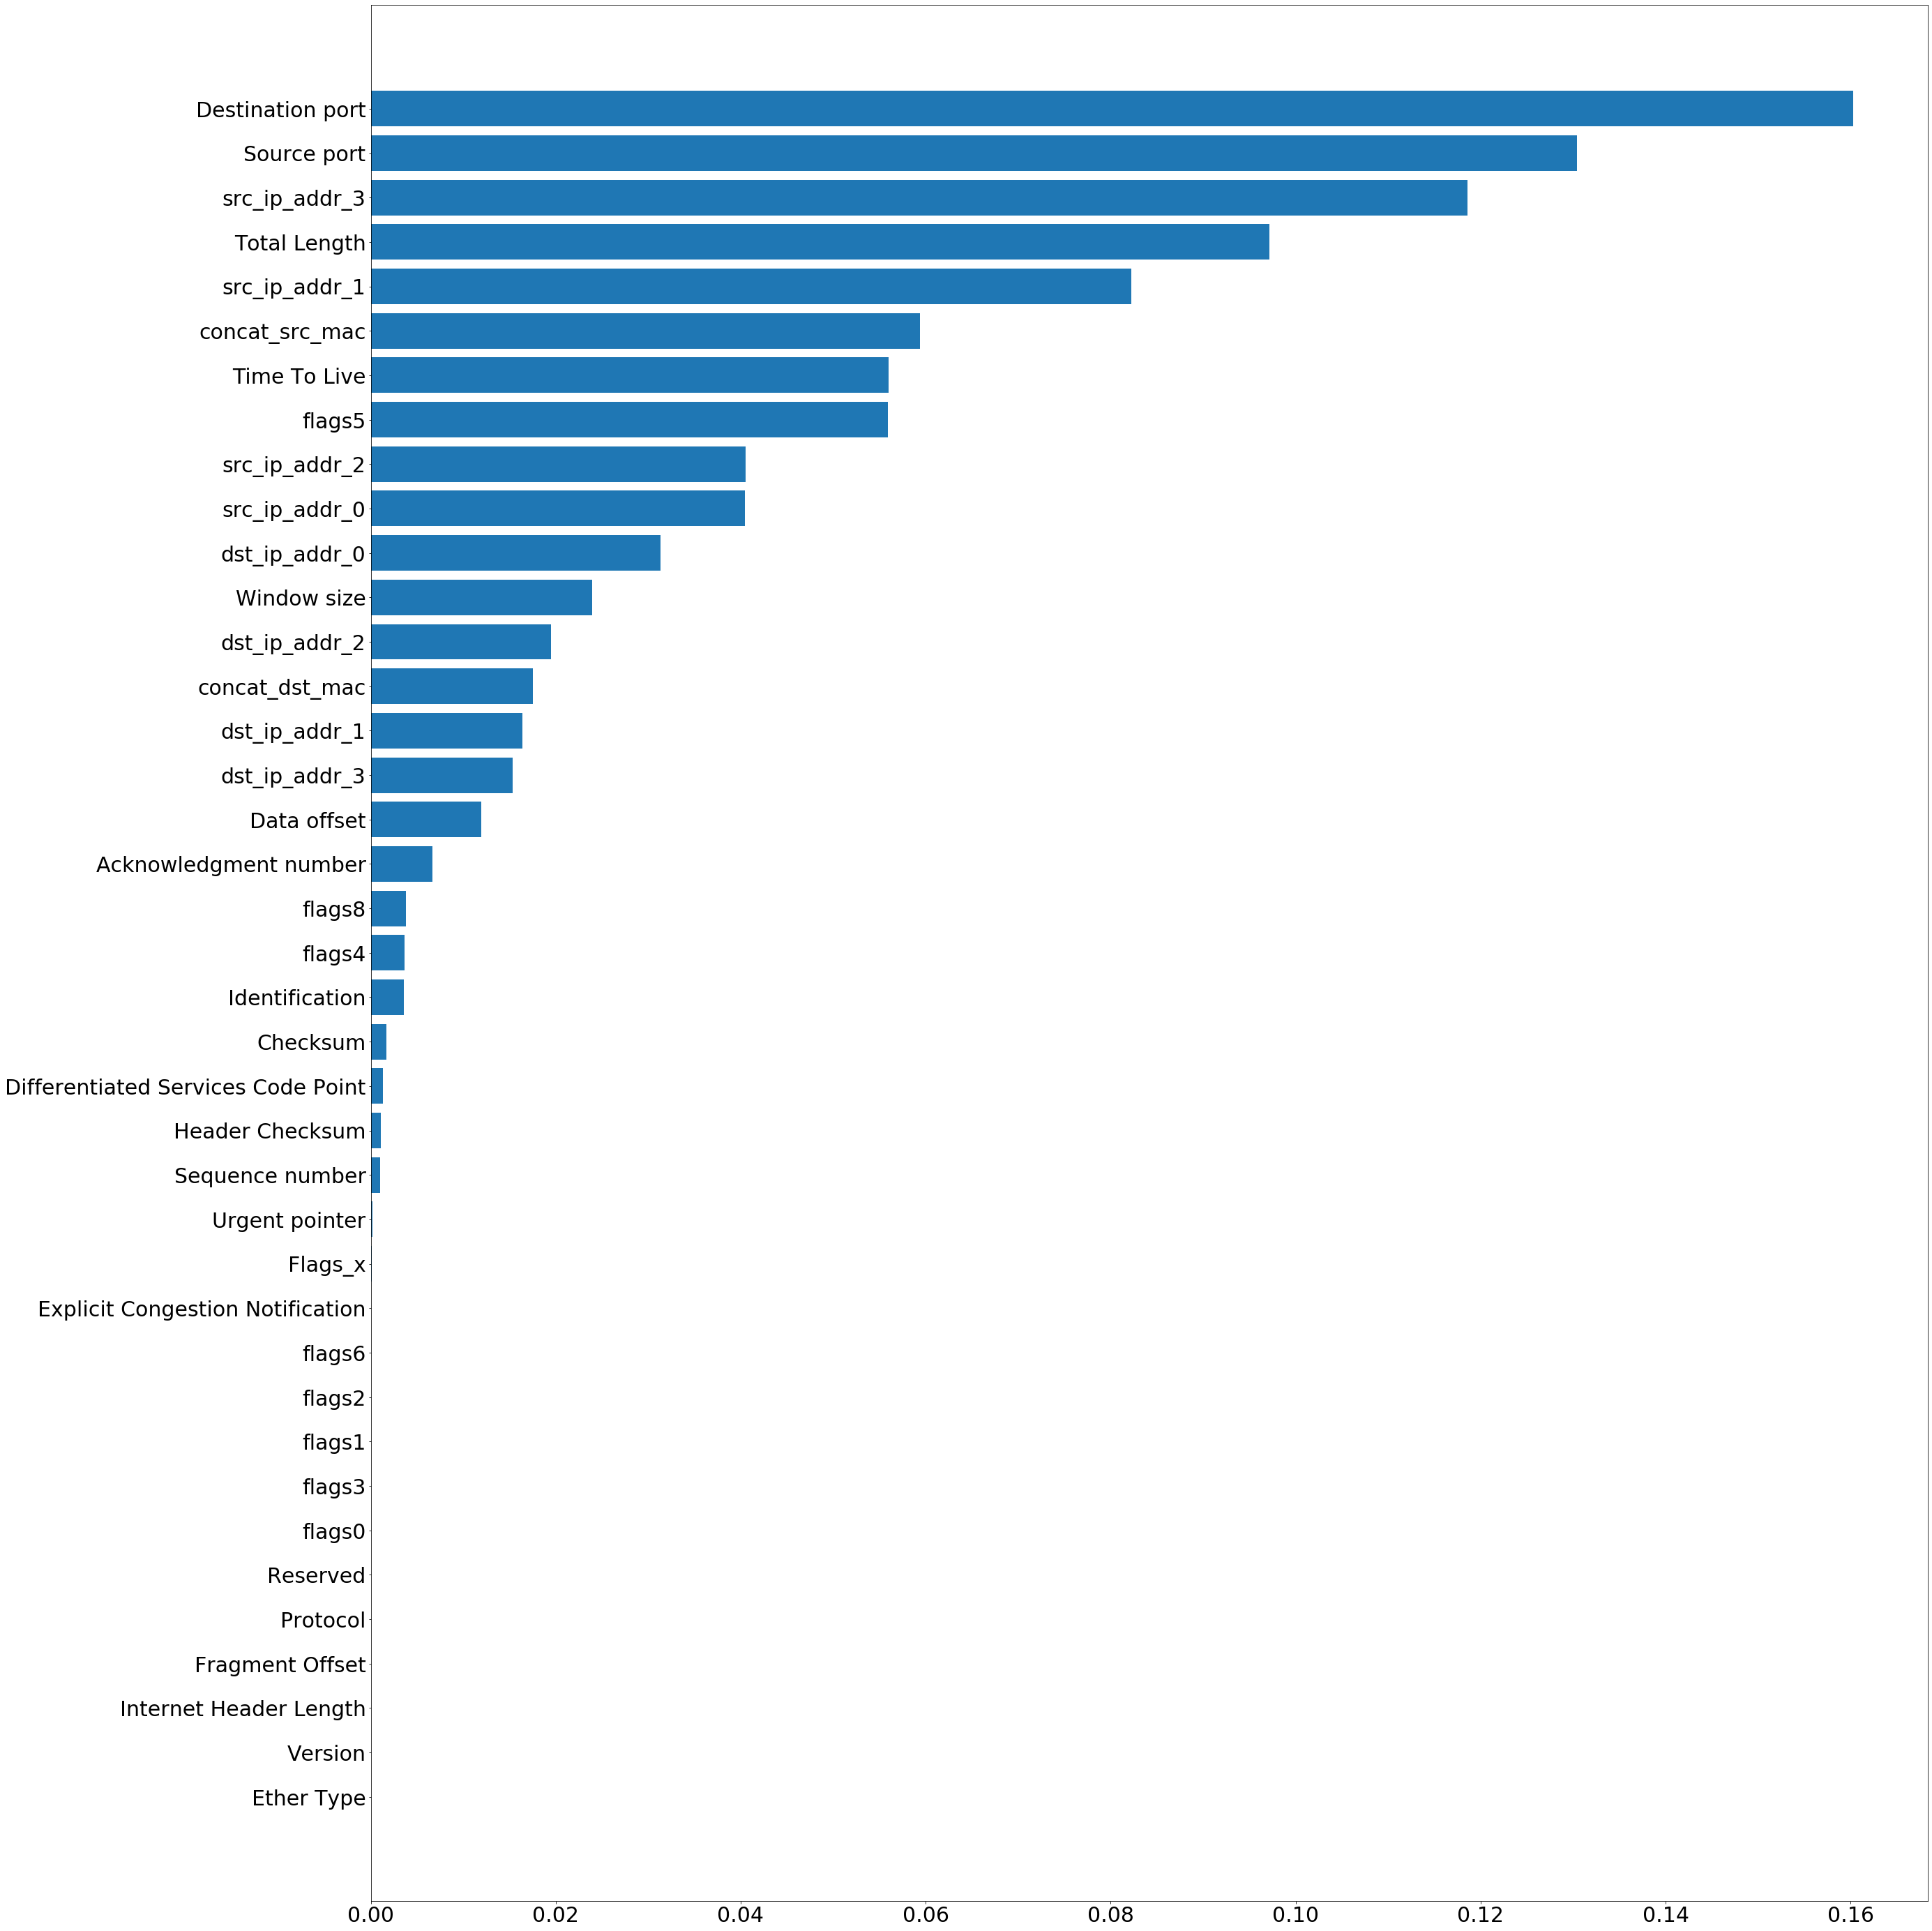

In [264]:
plt.figure(figsize=(40, 50))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.barh(imp_cols, imp_imp)
plt.savefig('E:/full_data/kcc_res/TCP_exp_img/49_feature_imp2.png')
plt.show()

In [175]:
train_cols = list(flag_ip_mac_tcp_train_df.columns)

In [171]:
fimp = forest.feature_importances_

In [174]:
len(fimp)

49

In [177]:
import matplotlib.pyplot as plt

In [191]:
imp_dic = {}
for c, i in zip(train_cols, fimp):
    imp_dic[c]=i

In [199]:
sort_imp = sorted(imp_dic.items(), key=(lambda x: x[1]), reverse=False)

In [200]:
sort_imp[0]

('Ether Type', 0.0)

In [201]:
imp_cols = []
imp_imp = []
for i in sort_imp:
    imp_cols.append(i[0])
    imp_imp.append(i[1])

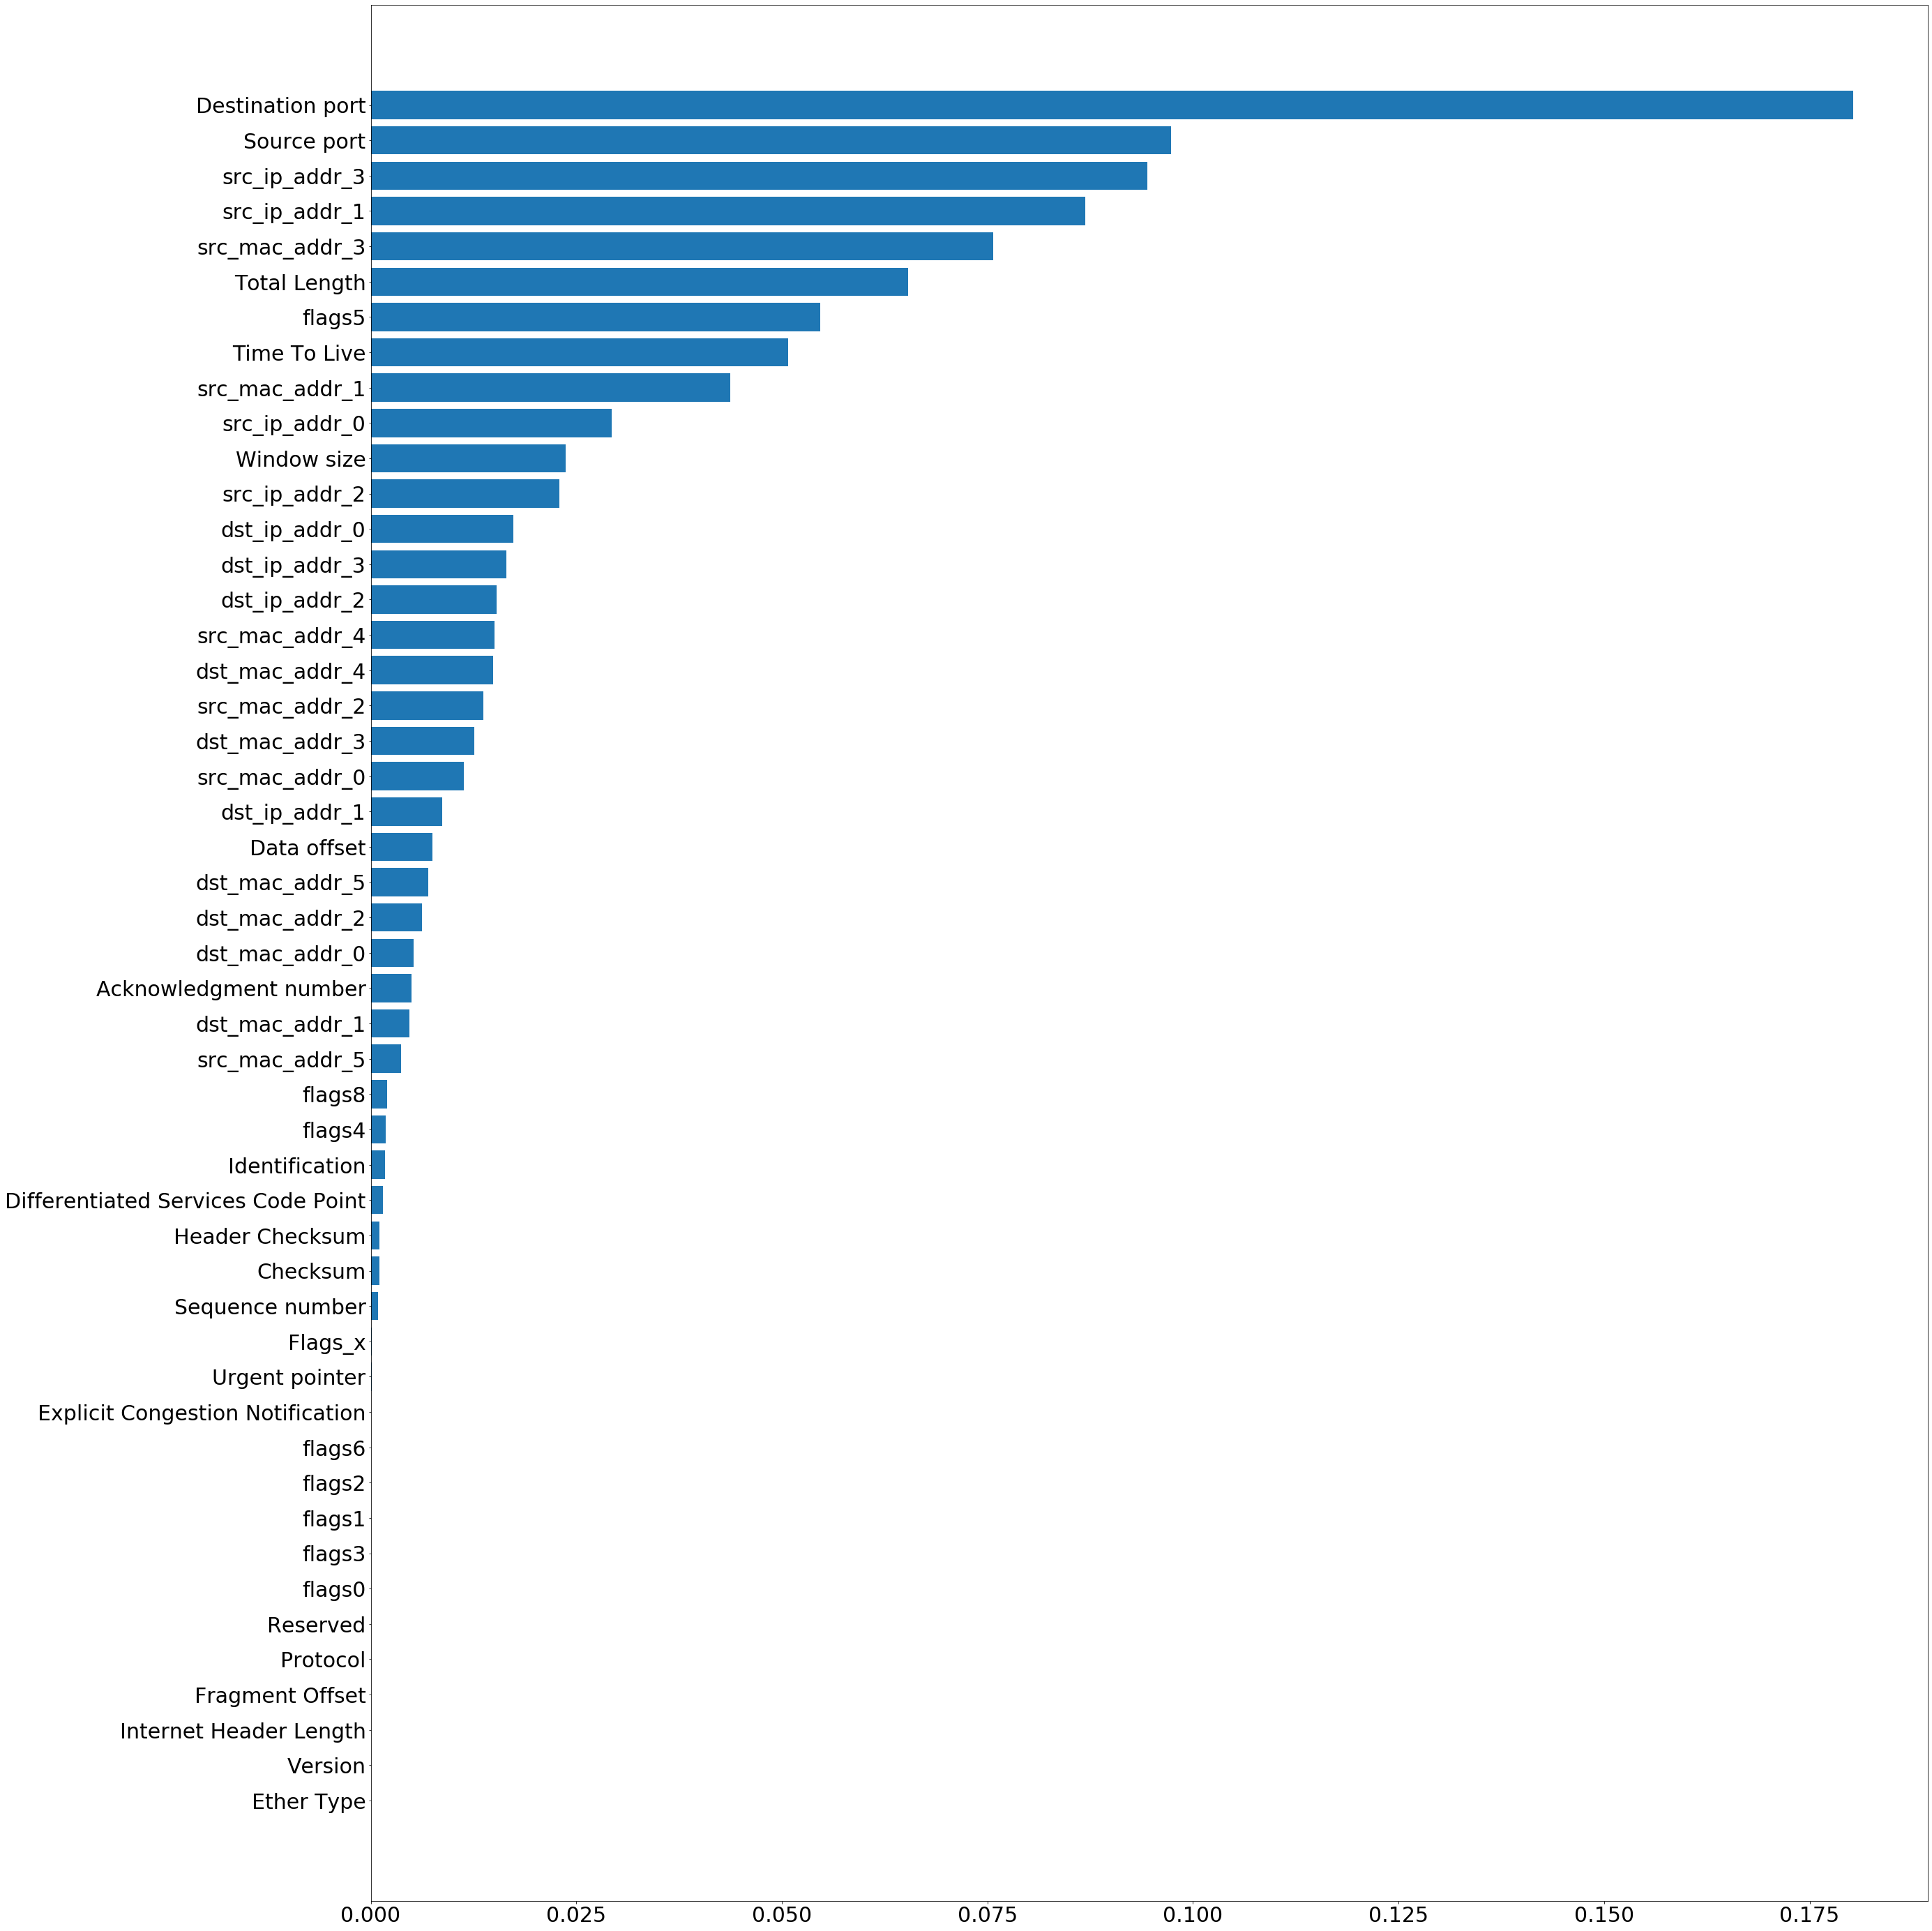

In [203]:
plt.figure(figsize=(40, 50))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.barh(imp_cols, imp_imp)
plt.savefig('E:/full_data/kcc_res/TCP_exp_img/49_feature_imp.png')
plt.show()

In [172]:
def graph_generator(model,importances, X):
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()